In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from kdg import kdn, kdcnn
from kdg.utils import generate_gaussian_parity, hellinger, plot_2dsim, generate_ood_samples, sample_unifrom_circle, get_ece
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import activations
from tensorflow.keras import backend as bknd
import timeit

### Visualize the data

<AxesSubplot: >

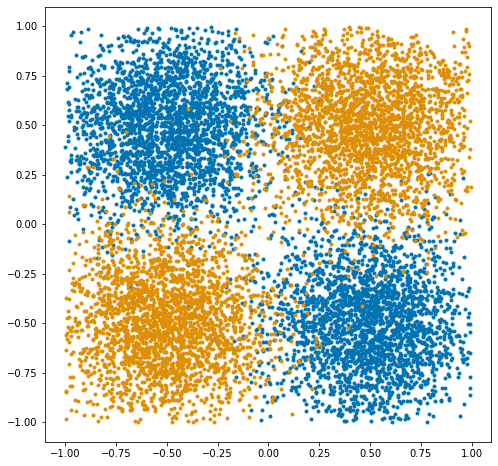

In [2]:
X, y = generate_gaussian_parity(10000)
plot_2dsim(X, y)

In [3]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 64,
        "verbose": False,
        "callbacks": [callback],
    }

In [4]:
# network architecture [1000, 1000, 1000, 1000, 2]
def getNN(input_size, num_classes):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [5]:
# train Vanilla NN
nn = getNN(input_size=2, num_classes=2)
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

Metal device set to: Apple M1 Max


2023-08-31 23:16:47.210497: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-31 23:16:47.210827: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-08-31 23:16:47.382893: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-31 23:16:47.581059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 95: early stopping


### Calculate posteriors and likelihoods using KDN

In [6]:
df = {}

t_0 = timeit.default_timer()
model_kdn = kdn(network=nn)
model_kdn.fit(X, y, k=2e8)
t_1 = timeit.default_timer()

print(f"Elapsed time: {t_1-t_0} s")
#define grids
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_nn = model_kdn.network.predict(grid_samples)
posterior_kdn, likelihoods_kdn = model_kdn.predict_proba(grid_samples, return_likelihood=True)
posterior_kdn_geod, likelihoods_kdn_geod = model_kdn.predict_proba(grid_samples, distance='Geodesic', return_likelihood=True)

posterior_nn = posterior_nn[:,0].reshape(400,400)
posterior_kdn = posterior_kdn[:,0].reshape(400,400)
class1_likelihoods = likelihoods_kdn[:,0].reshape(400,400)
class2_likelihoods = likelihoods_kdn[:,1].reshape(400,400)

posterior_kdn_geod = posterior_kdn_geod[:,0].reshape(400,400)
class1_likelihoods_geod = likelihoods_kdn_geod[:,0].reshape(400,400)
class2_likelihoods_geod = likelihoods_kdn_geod[:,1].reshape(400,400)

df['posterior_dn'] = posterior_nn
df['posterior_kdn'] = posterior_kdn
df['likelihood_class1'] = class1_likelihoods
df['likelihood_class2'] = class2_likelihoods
df['posterior_kdn_geod'] = posterior_kdn_geod
df['likelihood_class1_geod'] = class1_likelihoods_geod
df['likelihood_class2_geod'] = class2_likelihoods_geod

Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.42s/it]


Elapsed time: 68.74069495900001 s
  76/5000 [..............................] - ETA: 10s

2023-08-31 23:19:34.771509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5000/5000 [==============================] - 9s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:40<00:00, 68.16s/it]


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:35<00:00, 67.20s/it]


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:40<00:00, 68.16s/it]


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:48<00:00, 69.61s/it]


In [7]:
# get true posterior
tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
proba_true = 0.5*np.ones((400, 400))
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = np.flip(tmp.reshape(200, 200), axis=1)
proba_true[100:300, 100:300] = 1 - tmp
#df["true_proba"] = proba_true

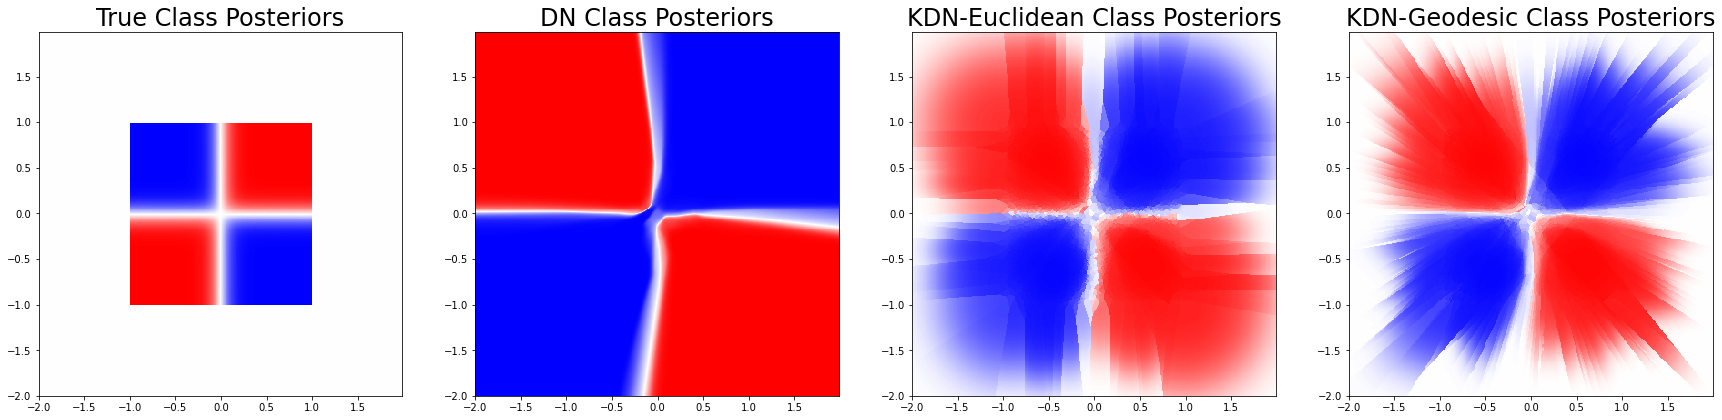

In [9]:
fig1, ax = plt.subplots(1, 4, figsize=(30, 150))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    1-posterior_nn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("DN Class Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    1-posterior_kdn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN-Euclidean Class Posteriors", fontsize=24)
ax[2].set_aspect("equal")

ax2 = ax[3].imshow(
    1-posterior_kdn_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title("KDN-Geodesic Class Posteriors", fontsize=24)
ax[3].set_aspect("equal")
plt.show()

### Visualize class likelihoods

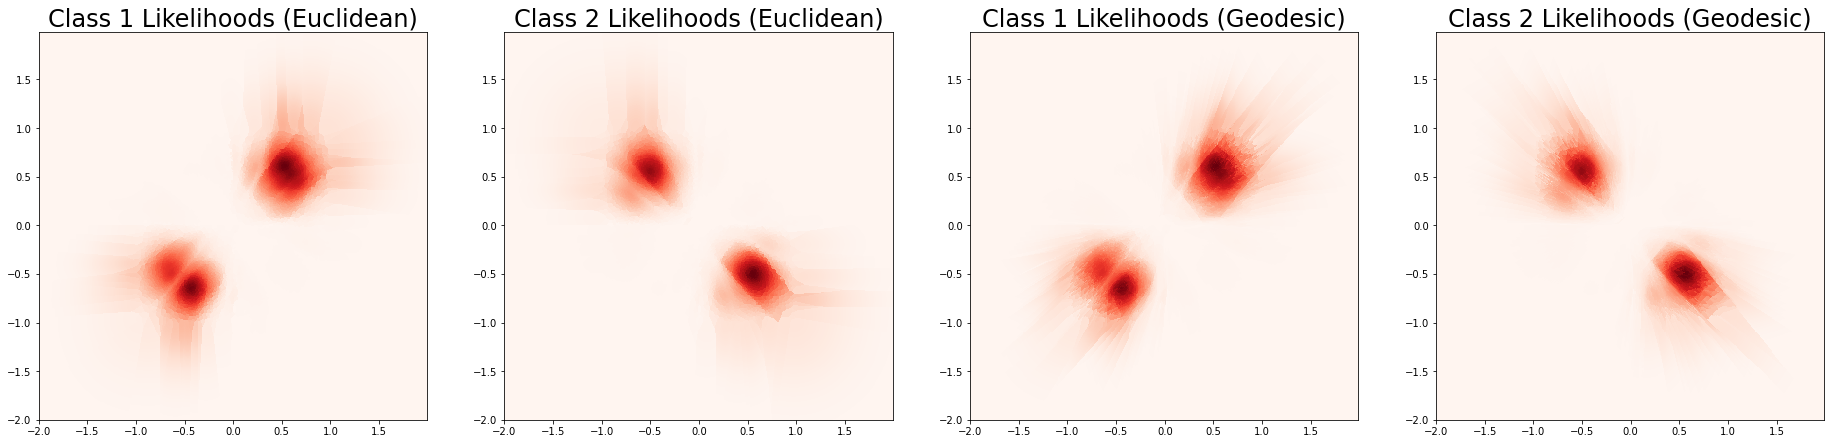

In [10]:
fig1, ax = plt.subplots(1, 4, figsize=(32, 8))

ax0 = ax[0].imshow(
    class1_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("Class 1 Likelihoods (Euclidean)", fontsize=24)
ax[0].set_aspect("equal")


ax1 = ax[1].imshow(
    class2_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("Class 2 Likelihoods (Euclidean)", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    class1_likelihoods_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("Class 1 Likelihoods (Geodesic)", fontsize=24)
ax[2].set_aspect("equal")

ax3 = ax[3].imshow(
    class2_likelihoods_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title("Class 2 Likelihoods (Geodesic)", fontsize=24)
ax[3].set_aspect("equal")

### Experiment with misclassification error and hellinger distance

In [22]:
mc_reps = 10
sample_size = [50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((true_posterior.ravel(), 1-true_posterior.ravel())).T
        
    
def experiment_in(sample, n_test, true_posterior):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)

    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, k=2e8)

    error_kdn = 1 - np.mean(model_kdn.predict(X_test)==y_test)
    error_kdn_geod = 1 - np.mean(model_kdn.predict(X_test, distance='Geodesic')==y_test)
    error_dn = 1 - np.mean(np.argmax(model_kdn.network.predict(X_test),axis=1)==y_test)
    
    proba_kdn = model_kdn.predict_proba(grid_samples)
    proba_kdn_geod = model_kdn.predict_proba(grid_samples, distance='Geodesic')
    proba_dn = model_kdn.network.predict(grid_samples)
    
    hellinger_dis_kdn = hellinger(true_posterior, proba_kdn)
    hellinger_dis_kdn_geod = hellinger(true_posterior, proba_kdn_geod)
    hellinger_dis_dn = hellinger(true_posterior, proba_dn)
    
    
    return error_kdn, error_kdn_geod, error_dn, hellinger_dis_kdn, hellinger_dis_kdn_geod, hellinger_dis_dn

def experiment_out(in_sample, r, n_test):
    mmcOut_dn = np.zeros(len(r),dtype=float)
    mmcOut_kdn = np.zeros(len(r),dtype=float)
    mmcOut_kdn_geod = np.zeros(len(r),dtype=float)
    
    X, y = generate_gaussian_parity(in_sample)
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, k=1e3)
    
    for ii, r_ in enumerate(r):
        X_ood = sample_unifrom_circle(n=n_test, r=r_)
        mmcOut_dn[ii] = np.mean(np.max(
            model_kdn.network.predict(X_ood), axis=1
            )
        )
        mmcOut_kdn[ii] = np.mean(np.max(model_kdn.predict_proba(X_ood), axis=1))
        mmcOut_kdn_geod[ii] = np.mean(np.max(model_kdn.predict_proba(X_ood, distance='Geodesic'), axis=1))
    
    return mmcOut_kdn, mmcOut_kdn_geod, mmcOut_dn
        
    
error_kdn_med = []
error_kdn_25 = []
error_kdn_75 = []
error_kdn_geod_med = []
error_kdn_geod_25 = []
error_kdn_geod_75 = []
error_dn_med = []
error_dn_25 = []
error_dn_75 = []

hellinger_kdn_med = []
hellinger_kdn_25 = []
hellinger_kdn_75 = []
hellinger_kdn_geod_med = []
hellinger_kdn_geod_25 = []
hellinger_kdn_geod_75 = []
hellinger_dn_med = []
hellinger_dn_25 = []
hellinger_dn_75 = []


mmcOut_kdn_med = []
mmcOut_kdn_25 = []
mmcOut_kdn_75 = []
mmcOut_kdn_geod_med = []
mmcOut_kdn_geod_25 = []
mmcOut_kdn_geod_75 = []
mmcOut_dn_med = []
mmcOut_dn_25 = []
mmcOut_dn_75 = []


#### do out-of-distribution results ####
r = np.arange(0,10.5,.5)
mmcOut_kdn = np.zeros((len(r),mc_reps), dtype=float)
mmcOut_kdn_geod = np.zeros((len(r),mc_reps), dtype=float)
mmcOut_dn = np.zeros((len(r),mc_reps), dtype=float)

for rep in range(mc_reps):
    mmcOut_kdn[:,rep], mmcOut_kdn_geod[:,rep], mmcOut_dn[:,rep] = experiment_out(1000, r, n_test)
    
    
mmcOut_kdn_med = np.median(mmcOut_kdn, axis=1)
mmcOut_kdn_25 = np.quantile(mmcOut_kdn, [0.25], axis=1)
mmcOut_kdn_75 = np.quantile(mmcOut_kdn, [0.75], axis=1)

mmcOut_kdn_geod_med = np.median(mmcOut_kdn_geod, axis=1)
mmcOut_kdn_geod_25 = np.quantile(mmcOut_kdn_geod, [0.25], axis=1)
mmcOut_kdn_geod_75 = np.quantile(mmcOut_kdn_geod, [0.75], axis=1)

mmcOut_dn_med = np.median(mmcOut_dn, axis=1)
mmcOut_dn_25 = np.quantile(mmcOut_dn, [0.25], axis=1)
mmcOut_dn_75 = np.quantile(mmcOut_dn, [0.75], axis=1)
    
        
#### do in-distribution results ####
for sample in sample_size:
    err_kdn = []
    err_kdn_geod = []
    err_dn = []
    hellinger_kdn = []
    hellinger_kdn_geod = []
    hellinger_dn = []
    
    for ii in range(mc_reps):
        a,b,c,d,e,f = experiment_in(sample, n_test, true_posterior) 
        
        err_kdn.append(a)
        err_kdn_geod.append(b)
        err_dn.append(c)
        hellinger_kdn.append(d)
        hellinger_kdn_geod.append(e)
        hellinger_dn.append(f)
        

    error_kdn_med.append(
        np.median(err_kdn)
    )
    error_kdn_25.append(
        np.quantile(err_kdn, [0.25])[0]
    )
    error_kdn_75.append(
        np.quantile(err_kdn, [0.75])[0]
    )
    
    error_kdn_geod_med.append(
        np.median(err_kdn_geod)
    )
    error_kdn_geod_25.append(
        np.quantile(err_kdn_geod, [0.25])[0]
    )
    error_kdn_geod_75.append(
        np.quantile(err_kdn_geod, [0.75])[0]
    )
    
    error_dn_med.append(
        np.median(err_dn)
    )
    error_dn_25.append(
        np.quantile(err_dn, [0.25])[0]
    )
    error_dn_75.append(
        np.quantile(err_dn, [0.75])[0]
    )
    
    
    hellinger_kdn_med.append(
        np.median(hellinger_kdn)
    )
    hellinger_kdn_25.append(
        np.quantile(hellinger_kdn, [0.25])[0]
    )
    hellinger_kdn_75.append(
        np.quantile(hellinger_kdn, [0.75])[0]
    )
    
    hellinger_kdn_geod_med.append(
        np.median(hellinger_kdn_geod)
    )
    hellinger_kdn_geod_25.append(
        np.quantile(hellinger_kdn_geod, [0.25])[0]
    )
    hellinger_kdn_geod_75.append(
        np.quantile(hellinger_kdn_geod, [0.75])[0]
    )
    
    hellinger_dn_med.append(
        np.median(hellinger_dn)
    )
    hellinger_dn_25.append(
        np.quantile(hellinger_dn, [0.25])[0]
    )
    hellinger_dn_75.append(
        np.quantile(hellinger_dn, [0.75])[0]
    )
    
    

df['error_kdn_med'] = error_kdn_med
df['error_kdn_25'] = error_kdn_25
df['error_kdn_75'] = error_kdn_75

df['error_kdn_geod_med'] = error_kdn_geod_med
df['error_kdn_geod_25'] = error_kdn_geod_25
df['error_kdn_geod_75'] = error_kdn_geod_75

df['error_dn_med'] = error_dn_med
df['error_dn_25'] = error_dn_25
df['error_dn_75'] = error_dn_75

df['hellinger_kdn_med'] = hellinger_kdn_med
df['hellinger_kdn_25'] = hellinger_kdn_25
df['hellinger_kdn_75'] = hellinger_kdn_75

df['hellinger_kdn_geod_med'] = hellinger_kdn_geod_med
df['hellinger_kdn_geod_25'] = hellinger_kdn_geod_25
df['hellinger_kdn_geod_75'] = hellinger_kdn_geod_75

df['hellinger_dn_med'] = hellinger_dn_med
df['hellinger_dn_25'] = hellinger_dn_25
df['hellinger_dn_75'] = hellinger_dn_75

df['mmcOut_kdn_med'] = mmcOut_kdn_med
df['mmcOut_kdn_25'] = mmcOut_kdn_25
df['mmcOut_kdn_75'] = mmcOut_kdn_75

df['mmcOut_kdn_geod_med'] = mmcOut_kdn_geod_med
df['mmcOut_kdn_geod_25'] = mmcOut_kdn_geod_25
df['mmcOut_kdn_geod_75'] = mmcOut_kdn_geod_75

df['mmcOut_dn_med'] = mmcOut_dn_med
df['mmcOut_dn_25'] = mmcOut_dn_25
df['mmcOut_dn_75'] = mmcOut_dn_75

2023-09-01 08:01:46.262389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 79: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57it/s]

26/32 [=======================>......] - ETA: 0s


2023-09-01 08:01:56.485143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]
2023-09-01 08:02:14.952446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 50: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 08:02:21.515103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]
2023-09-01 08:02:39.512742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 72: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 08:02:48.335027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]
2023-09-01 08:03:06.444614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 64: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 08:03:14.400569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]
2023-09-01 08:03:32.499114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 72: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 08:03:41.353888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]
2023-09-01 08:03:59.161703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 86: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 08:04:09.703203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]
2023-09-01 08:04:27.962726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 76: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 08:04:37.152889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]
2023-09-01 08:04:55.094084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 51: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 08:05:01.779600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.58it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]
2023-09-01 08:05:19.913472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 38: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 08:05:25.287173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]
2023-09-01 08:05:43.851981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 84: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 08:05:54.155679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]
2023-09-01 08:06:12.135714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 251.89it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 69.89it/s]
2023-09-01 08:06:14.281884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.01it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:06:20.482908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 38: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 255.06it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 77.83it/s]
2023-09-01 08:06:21.221998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.92it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:06:27.343182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 26: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.08it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 71.88it/s]
2023-09-01 08:06:28.052116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.91it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:06:34.157646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.91it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 73.25it/s]
2023-09-01 08:06:36.186074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.06it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:06:42.211355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 273.30it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 78.50it/s]
2023-09-01 08:06:42.884726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.88it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:06:48.981529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 28: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 285.93it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 70.89it/s]
2023-09-01 08:06:49.721040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.88it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:06:55.822757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 271.18it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 74.76it/s]
2023-09-01 08:06:57.887307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.02it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:07:03.938139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 37: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 270.74it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 61.75it/s]
2023-09-01 08:07:04.758281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:07:10.834614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 34: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.27it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 75.55it/s]
2023-09-01 08:07:11.619594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.86it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:07:17.756075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 306.71it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 60.27it/s]
2023-09-01 08:07:19.852002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.97it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:07:25.936521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 83: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 137.05it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.46it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 08:07:28.020642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:07:35.053502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 114: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 147.24it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 49.03it/s]
2023-09-01 08:07:37.506262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:07:44.536760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.91it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.59it/s]
2023-09-01 08:07:48.644413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:07:55.776001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 125.25it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.80it/s]
2023-09-01 08:07:59.584426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:08:06.732753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 124: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 132.69it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.74it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 08:08:09.322164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:08:16.424571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 156.27it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.31it/s]
2023-09-01 08:08:20.216428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:08:27.322922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 21: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 143.55it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 48.53it/s]
2023-09-01 08:08:28.435775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:08:35.577856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 173: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 149.98it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.73it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 08:08:38.866388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:08:45.939479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 126.19it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.84it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 08:08:47.114407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:08:54.257377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 144.70it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.21it/s]
2023-09-01 08:08:58.007292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:09:05.144187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.98it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.87it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 08:09:08.565599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.15s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:09:24.012670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 100: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.61it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.54it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 08:09:30.937638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.13s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:09:46.091646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 73: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.04it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.01it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 08:09:51.387343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.15s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:10:06.687927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 92: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.87it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.93it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 08:10:12.980393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.10s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:10:27.943077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 111: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.72it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.64it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-01 08:10:35.281068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.13s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:10:50.375949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.22it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.26it/s]
2023-09-01 08:10:53.992767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.11s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:11:09.396535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 103: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.87it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.38it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 08:11:16.459768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.15s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:11:31.627904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 101: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.75it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.71it/s]


 1/32 [..............................] - ETA: 2s

2023-09-01 08:11:38.530385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.15s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:11:53.729857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 96: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.88it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.98it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 08:12:00.360902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.16s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:12:15.649301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 125: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.77it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.12it/s]
2023-09-01 08:12:23.926586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.19s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:12:39.387928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 44: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-01 08:12:46.451681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.29s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:13:12.489282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 81: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


17/32 [==============>...............] - ETA: 0s

2023-09-01 08:13:23.742153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.55s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:13:51.205529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 43: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 08:13:58.162529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.36s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:14:24.643018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 137: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 08:14:41.351249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.23s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:15:07.081898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 72: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 08:15:16.936809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.22s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:15:42.594959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 92: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


23/32 [====================>.........] - ETA: 0s

2023-09-01 08:15:54.749819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.29s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:16:20.862303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 20: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]

26/32 [=======================>......] - ETA: 0s


2023-09-01 08:16:25.427512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.31s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:16:51.598913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 48: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


23/32 [====================>.........] - ETA: 0s

2023-09-01 08:16:59.077117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.35s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:17:25.480192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 115: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


23/32 [====================>.........] - ETA: 0s

2023-09-01 08:17:40.292774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.29s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:18:06.332883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 76: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


22/32 [===================>..........] - ETA: 0s

2023-09-01 08:18:17.367795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.20s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 08:18:42.954383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 52: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.77s/it]


Calculating distance
Calculating distance


ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [29]:
error_kdn_geod_med

[0.07499999999999996,
 0.06849999999999995,
 0.05900000000000005,
 0.049500000000000044]

In [31]:
experiment_in(5000, n_test, true_posterior)

2023-09-01 08:28:23.851033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.04s/it]


Calculating distance
Calculating distance


ValueError: cannot reshape array of size 0 into shape (0,newaxis)

### Save the result

In [ ]:
import pickle
filename = 'results/gxor.pickle'

with open(filename, 'wb') as f:
    pickle.dump(df,f)

In [ ]:
sample_size = [50, 100, 500, 1000, 5000, 10000]

sns.set_context('talk')
fig, ax = plt.subplots(1,3, figsize=(24,8))


ax[0].plot(sample_size, df['error_kdn_med'], c="r", label='KDN-Euclidean')
ax[0].plot(sample_size, df['error_dn_med'], c="k", label='DN')
ax[0].plot(sample_size, df['error_kdn_geod_med'], c="b", label='KDN-Geodesic')

ax[0].fill_between(sample_size, df['error_kdn_25'], df['error_kdn_75'], facecolor='r', alpha=.3)
ax[0].fill_between(sample_size, df['error_dn_25'], df['error_dn_75'], facecolor='k', alpha=.3)
ax[0].fill_between(sample_size, df['error_kdn_geod_25'], df['error_kdn_geod_75'], facecolor='b', alpha=.3)

ax[0].set_xscale('log')
ax[0].set_xlabel('Sample size')
ax[0].set_ylabel('Generalization Error')

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)




ax[1].plot(sample_size, df['hellinger_kdn_med'], c="r", label='KDN-Euclidean')
ax[1].plot(sample_size, df['hellinger_dn_med'], c="k", label='DN')
ax[1].plot(sample_size, df['hellinger_kdn_geod_med'], c="b", label='KDN-Geodesic')

ax[1].fill_between(sample_size, df['hellinger_kdn_25'], df['hellinger_kdn_75'], facecolor='r', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_dn_25'], df['hellinger_dn_75'], facecolor='k', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_kdn_geod_25'], df['hellinger_kdn_geod_75'], facecolor='b', alpha=.3)

ax[1].set_xscale('log')
ax[1].set_xlabel('Sample size')
ax[1].set_ylabel('Hellinger Distance')

right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)


r = np.arange(0,10.5,.5)
ax[2].plot(r, df['mmcOut_kdn_med'], c="r", label='KDN-Euclidean')
ax[2].plot(r, df['mmcOut_dn_med'], c="k", label='DN')
ax[2].plot(r, df['mmcOut_kdn_geod_med'], c="b", label='KDN-Geodesic')

ax[2].fill_between(r, df['mmcOut_kdn_25'], df['mmcOut_kdn_75'], facecolor='r', alpha=.3)
ax[2].fill_between(r, df['mmcOut_dn_25'], df['mmcOut_dn_75'], facecolor='k', alpha=.3)
ax[2].fill_between(r, df['mmcOut_kdn_geod_25'], df['mmcOut_kdn_geod_75'], facecolor='r', alpha=.3)

#ax[3].set_xscale('log')
ax[2].set_xlabel('Distance')
ax[2].set_ylabel('Mean Max Confidence')

ax[2].legend(fontsize=35, frameon=False)

right_side = ax[2].spines["right"]
right_side.set_visible(False)
top_side = ax[2].spines["top"]
top_side.set_visible(False)

### OOD detection metrics

In [78]:
def fpr_at_95_tpr(conf_t, conf_f):
    TPR = 95
    PERC = np.percentile(conf_t, 100-TPR)
    FP = np.sum(conf_f >=  PERC)
    FPR = np.sum(conf_f >=  PERC)/len(conf_f)
    return FPR, PERC

In [79]:
sample = 1000
reps = 10
n_test = 1000
true_labels = np.hstack((np.ones(n_test, ), np.zeros(n_test, )))

roc_dn = []
roc_kdn = []

fpr_dn = []
fpr_kdn = []
reps_list = []

for ii in range(reps):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)
    X_ood = generate_ood_samples(n_test)

    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(k=1, network=nn)
    model_kdn.fit(X, y)

    dn_in_conf = np.max(model_kdn.network.predict(X_test), axis=1)
    dn_out_conf = np.max(model_kdn.network.predict(X_ood), axis=1)
    dn_conf = np.hstack((dn_in_conf, dn_out_conf))
    roc_dn.append(
        roc_auc_score(true_labels, dn_conf)
    )
    fpr_dn.append(
        fpr_at_95_tpr(dn_in_conf, dn_out_conf)
    )
    
    

    kdn_in_conf = np.max(model_kdn.predict_proba(X_test), axis=1)
    kdn_out_conf = np.max(model_kdn.predict_proba(X_ood), axis=1)
    kdn_conf = np.hstack((kdn_in_conf, kdn_out_conf))
    roc_kdn.append(
        roc_auc_score(true_labels, kdn_conf)
    )
    fpr_kdn.append(
        fpr_at_95_tpr(kdn_in_conf, kdn_out_conf)
    )

    reps_list.append(ii)

2023-03-06 09:26:59.365859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 129: early stopping
Calculating weight for  1000  samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:05<00:00,  7.98it/s]



 1/32 [..............................] - ETA: 2s

2023-03-06 09:29:19.360454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 09:29:19.846879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping
Calculating weight for  1000  samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.01it/s]



 1/32 [..............................] - ETA: 2s

2023-03-06 09:31:31.755608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 09:31:32.253041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping
Calculating weight for  1000  samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:41<00:00,  1.12s/it]



 1/32 [..............................] - ETA: 2s

2023-03-06 09:50:17.663610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 09:50:18.167306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 92: early stopping
Calculating weight for  1000  samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [23:45<00:00,  1.43s/it]



 1/32 [..............................] - ETA: 2s

2023-03-06 10:14:14.191732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:14:14.710628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 76: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:02<00:00,  8.16it/s]



 1/32 [..............................] - ETA: 2s

2023-03-06 10:16:26.411805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:16:26.905171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 50: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:07<00:00,  7.83it/s]



 1/32 [..............................] - ETA: 2s

2023-03-06 10:18:41.104489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:18:41.582798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 114: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:06<00:00,  7.93it/s]



 1/32 [..............................] - ETA: 2s

2023-03-06 10:21:01.282403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:21:01.783859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.06it/s]



 1/32 [..............................] - ETA: 2s

2023-03-06 10:23:10.871671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:23:11.402165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 56: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.03it/s]



 1/32 [..............................] - ETA: 2s

2023-03-06 10:25:23.137776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:25:23.632406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:07<00:00,  7.84it/s]



 1/32 [..............................] - ETA: 2s

2023-03-06 10:27:35.285419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


In [80]:
# obtain the AUROC and FPR@95 scores

# AUROC
print("KDN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_kdn), np.std(roc_kdn)))
print("DN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_dn), np.std(roc_dn)))

KDN AUROC = 0.955 +/- 0.003
DN AUROC = 0.324 +/- 0.074


In [81]:
# FPR@95
print("KDN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_kdn), np.std(fpr_kdn)))
print("DN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_dn), np.std(fpr_dn)))

KDN FPR@95 = 0.504 +/- 0.356
DN FPR@95 = 0.910 +/- 0.081
